In [2]:
import os
print(os.getcwd())

/home/nguyen/Desktop/learning-nlp/news_sentiment


In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
import string

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
# from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, LSTM, SpatialDropout1D

from keras.losses import CategoricalCrossentropy

import tensorflow as tf

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

print('Working directory: ', os.getcwd())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Working directory:  /home/nguyen/Desktop/learning-nlp/news_sentiment
Num GPUs Available:  1


[nltk_data] Downloading package wordnet to /home/nguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nguyen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2022-04-20 16:31:11.498982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 16:31:11.499168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 16:31:11.499265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node

'/device:GPU:0'

In [16]:
DATASET = './datasets/all-data.csv'
CSV_ENCODING = 'ISO-8859-1'

In [17]:
df = pd.read_csv(DATASET, encoding=CSV_ENCODING, header=None)
df.columns = ['label', 'text']
df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


DESCRIBE:
########
          label                                               text
count      4846                                               4846
unique        3                                               4838
top     neutral  TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq       2879                                                  2
CHECK NULL: 
 label    0
text     0
dtype: int64
########


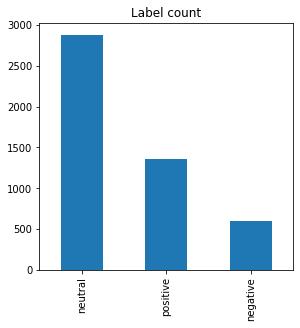

In [18]:
print("DESCRIBE:")
print("########")
print(df.describe())
print('CHECK NULL: \n', df.isnull().sum())
print("########")
plt.subplot(221)
df['label'].value_counts().plot(kind="bar", title="Label count", figsize = (10,10))
plt.show()

### Clean the doc

In [19]:
def clean_text(text):
    table = str.maketrans("", '', string.punctuation)
    text = text.translate(table)

    stop_words = stopwords.words('english')
    # porter = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    tokens = text.split(" ")

    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words and word.isalpha()]

    text = (" ").join(tokens)
    text = text.lower()

    return text 

processed_df = df.copy(deep=True)

processed_df['text'] = processed_df['text'].apply(clean_text)

print(processed_df.head())

print(df['text'][0])
print(processed_df['text'][0])


      label                                               text
0   neutral  according gran company plan move production ru...
1   neutral  technopolis plan develop stage area le square ...
2  negative  international electronic industry company elco...
3  positive  new production plant company would increase ca...
4  positive  according company updated strategy year baswar...
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
according gran company plan move production russia although company growing


### Building Vocab from dataset

In [20]:
# build vocab
docs = list() 
labels = list()
for index, row in processed_df.iterrows():
    docs.append(row['text'])
    labels.append(row['label'])

print("sample texts: ", docs[: 5])

tokenizer = Tokenizer()

tokenizer.fit_on_texts(docs)

vocab = tokenizer.word_index

to_write = list()

for key, value in vocab.items():
    to_write.append("{}:{}".format(key, value))

with open('vocab.txt', 'w') as file:
    file.write("\n".join(to_write))

encoded = tokenizer.texts_to_sequences(docs)

max_len = max([len(s) for s in encoded])

#Pad sequences to form x_train 
X = pad_sequences(encoded, max_len, padding="post")
#one-hot encode label
binarizer = LabelBinarizer()
y = binarizer.fit_transform(labels)

print("Feature vector: {}\n x length = {}, shape={}".format(X[:5], len(X), X.shape))
print("Label: {}\n y length = {}, shape={}".format(y[: 5], len(y), y.shape))

sample texts:  ['according gran company plan move production russia although company growing', 'technopolis plan develop stage area le square meter order host company working computer technology telecommunication statement said', 'international electronic industry company elcoteq laid ten employee tallinn facility contrary earlier layoff company contracted rank office worker daily postimees reported', 'new production plant company would increase capacity meet expected increase demand would improve use raw material therefore increase production profitability', 'according company updated strategy year basware target longterm net sale growth range operating profit margin net sale']
Feature vector: [[  50 2865    2  109  482   46   81 2294    2  581    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [ 648  109  684  943   72  582  529 1472   41 2866    2  616  727   35
   552  400    3    0    0    0    0 

In [34]:
def summarize_diagnostic(history, path = ''):
    plt.figure(figsize=(8,8))
    plt.figtext(0.5, 1, path, ha='center', fontsize=18)
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(history.history['loss'], color="blue", label="train loss")
    plt.plot(history.history['val_loss'], color="red", label="validation loss")
    plt.legend()
    plt.subplot(212)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color="blue", label="train accuracy")
    plt.plot(history.history['val_accuracy'], color="red", label="validation accuracy")
    plt.legend()
    if(path!= ''):
        plt.savefig(path, bbox_inches="tight", dpi = 150)

def build_base_model(vocab_size, max_len_token):
    model = Sequential()
    #NOTE: important!!!, vocab_size + 1 is a must, otherwise it'll produce errors during validation state
    #it happens when an unknown word appear
    model.add(Embedding(vocab_size + 1, 100, embeddings_initializer='he_uniform', input_length=max_len_token))
    model.add(Conv1D(filters=32, kernel_size = 8, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

    return model

def build_lstm(vocab_size, max_len_token):
    model = Sequential()
    #NOTE: important!!!, vocab_size + 1 is a must, otherwise it'll produce errors during validation state
    #it happens when an unknown word appear
    model.add(Embedding(vocab_size + 1, 100, embeddings_initializer='he_uniform', input_length=max_len_token))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

    return model

model = build_base_model(len(vocab), max_len)

lstm = build_lstm(len(vocab), max_len)

model.summary()

lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 36, 100)           842800    
                                                                 
 conv1d_5 (Conv1D)           (None, 29, 32)            25632     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 14, 32)            0         
                                                                 
 flatten_6 (Flatten)         (None, 448)               0         
                                                                 
 dense_15 (Dense)            (None, 100)               44900     
                                                      

X shape:  (4846, 36)
y shape:  (4846, 3)
x train shape:  (3876, 36)
y train shape:  (3876, 3)
x valid shape:  (970, 36)
y valid shape:  (970, 3)
Epoch 1/50
122/122 [==============================] - 11s 79ms/step - loss: 0.9006 - accuracy: 0.6127 - val_loss: 0.7854 - val_accuracy: 0.6526
Epoch 2/50
122/122 [==============================] - 9s 77ms/step - loss: 0.6312 - accuracy: 0.7317 - val_loss: 0.7453 - val_accuracy: 0.6907
Epoch 3/50
122/122 [==============================] - 9s 78ms/step - loss: 0.4627 - accuracy: 0.8104 - val_loss: 0.7931 - val_accuracy: 0.6918
Epoch 4/50
122/122 [==============================] - 10s 78ms/step - loss: 0.3865 - accuracy: 0.8357 - val_loss: 0.9365 - val_accuracy: 0.6670
Epoch 5/50
122/122 [==============================] - 10s 79ms/step - loss: 0.3469 - accuracy: 0.8493 - val_loss: 0.9821 - val_accuracy: 0.6763
Epoch 6/50
122/122 [==============================] - 10s 78ms/step - loss: 0.2775 - accuracy: 0.8824 - val_loss: 1.1903 - val_accuracy: 

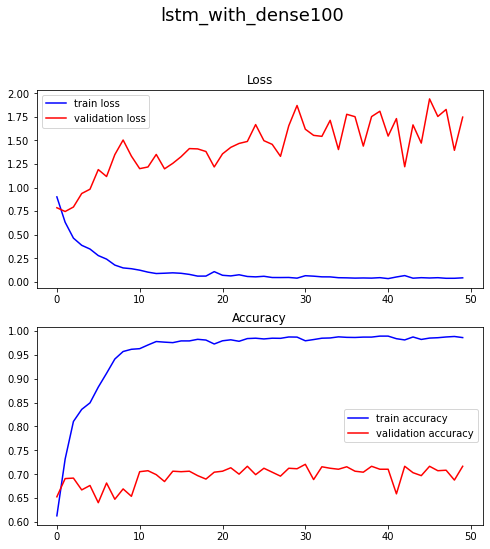

In [35]:
#Train
epochs = 5

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("x train shape: ", x_train.shape )
print("y train shape: ", y_train.shape )
print("x valid shape: ", x_valid.shape )
print("y valid shape: ", y_valid.shape )

# history = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], epochs = epochs)
history = lstm.fit(x_train, y_train, validation_data=[x_valid, y_valid], epochs = epochs)

summarize_diagnostic(history, 'test.jpg')

loss,acc = model.evaluate(x_valid, y_valid)

print("Test loss: {}, test accuracy: {}".format(loss, acc))